In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
import matplotlib.pyplot as plt
import tensorflow.python.keras.backend as K

2025-01-02 21:11:25.082188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 21:11:25.085639: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-02 21:11:25.096499: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-02 21:11:25.116607: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-02 21:11:25.122249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-02 21:11:25.136946: I tensorflow/core/platform/cpu_feature_gu

In [4]:
IMAGE_SIZE = 64
BATCH_SIZE = 8
CHANNELS = 3
EPOCHS = 30

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


I0000 00:00:1732450552.341662   62585 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-24 13:15:52.342475: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [7]:
len(dataset)

2580

The length of the dataset is 645 because every element in it is a batch of 32
images. 

$645 \cdot 32 = 20640$ images

But there are 20638 images in the dataset, meaning that the last batch is 
incomplete.

2024-11-24 13:16:28.102735: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


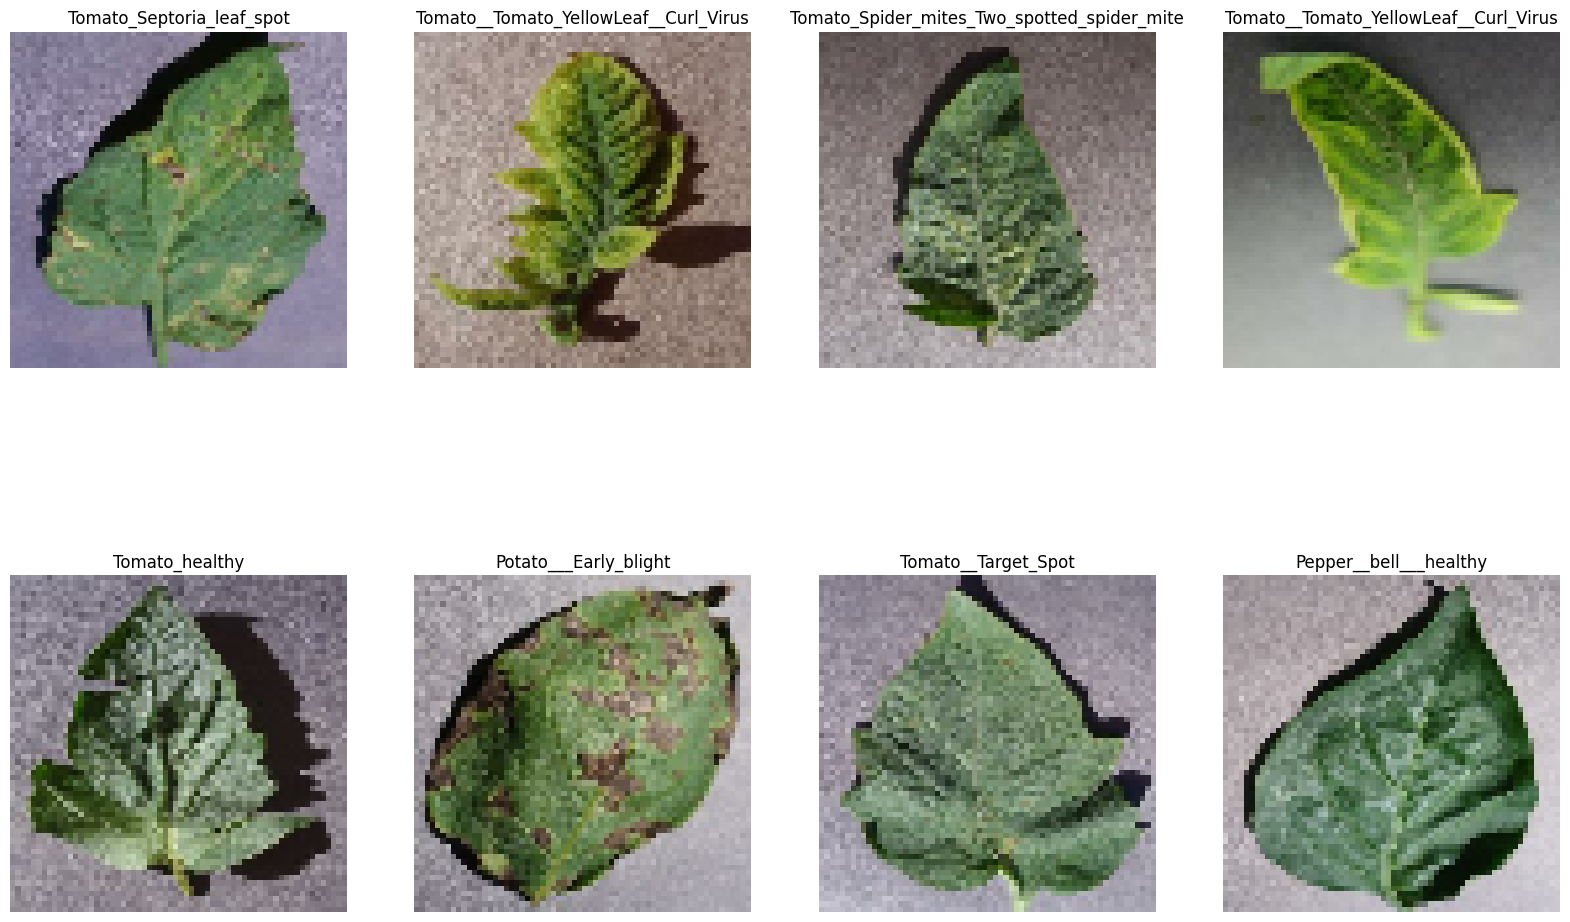

In [8]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape, label_batch.shape)
    for i in range (8):
        ax = plt.subplot(3, 4, i + 1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_size = 0.70
len(dataset)*train_size

1805.9999999999998

In [10]:
train_ds = dataset.take(1805)

In [11]:
len(train_ds)

1805

In [12]:
test_ds = dataset.skip(1805)
len(test_ds)

775

In [13]:
val_size = 0.15
len(dataset)*val_size

387.0

In [14]:
val_ds = test_ds.take(387)
len(val_ds)

387

In [15]:
test_ds = test_ds.skip(387)
len(test_ds)

388

In [16]:
def get_tf_dataset_splits(ds, train_split = 0.7, val_split = 0.15, 
                          shuffle = True, 
                          shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_tf_dataset_splits(dataset)

In [18]:
len(train_ds)

1805

In [19]:
len(val_ds)

387

In [20]:
len(test_ds)

388

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
len(class_names)

15

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# model = models.Sequential([
#     layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.Rescaling(1.0/255),
#     layers.RandomFlip("horizontal_and_vertical"),
#     layers.RandomRotation(0.2),
#     layers.RandomZoom(0.2),
#     layers.RandomContrast(0.2),

#     layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),

#     layers.Conv2D(64, (3,3), activation="relu"),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),

#     layers.Conv2D(128, (3,3), activation="relu"),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2,2)),
#     layers.Dropout(0.3),

#     layers.GlobalAveragePooling2D(),
#     layers.Dense(128, activation="relu"),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(n_classes, activation="softmax"),
# ])

model = models.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.Conv2D(32, (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

/home/osita/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (8, 64, 64, 3)         │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (8, 62, 62, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (8, 31, 31, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (8, 29, 29, 64)        │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (8, 14, 14, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (8, 12, 12, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (8, 6, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (8, 2304)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (8, 64)                │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (8, 15)                │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,815 (800.06 KB)

 Trainable params: 204,815 (800.06 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.optimizers.schedules import ExponentialDecay

# initial_learning_rate = 1e-3
# lr_schedule = ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=10000,
#     decay_rate=0.9,
#     staircase=True)

# model.compile(optimizer=Adam(learning_rate=lr_schedule),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [27]:
from keras.callbacks import CSVLogger
csv_logger = CSVLogger('training.log', separator=',', append=False)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks=[csv_logger]
)

Epoch 1/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 69s 33ms/step - accuracy: 0.2967 - loss: 2.1517 - val_accuracy: 0.5963 - val_loss: 1.2119
Epoch 2/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.6191 - loss: 1.1621 - val_accuracy: 0.6922 - val_loss: 0.8925
Epoch 3/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.7068 - loss: 0.8651 - val_accuracy: 0.7028 - val_loss: 0.8463
Epoch 4/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.7558 - loss: 0.6963 - val_accuracy: 0.8007 - val_loss: 0.5641
Epoch 5/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.7958 - loss: 0.5936 - val_accuracy: 0.8375 - val_loss: 0.4630
Epoch 6/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 56s 31ms/step - accuracy: 0.8190 - loss: 0.5329 - val_accuracy: 0.8314 - val_loss: 0.4855
Epoch 7/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 55s 30ms/step - accuracy: 0.8258 - loss: 0.5106 - val_accuracy: 0.8401 - val_loss: 0.4492
Epoch 8/30
1805/1805 ━━━━━━━━━━━━━━━━━━━━ 54s 30ms/step - accuracy: 0.8475 -

- Train split = 70/15/15
- Shap XAI
- Graph the training *
- Save the model

Tried training for 10 epochs first.
Tried training for 20 epochs second.
Now, I'll try training for 15 epochs.

In [28]:
model.evaluate(test_ds)

388/388 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9379 - loss: 0.1742


[0.1789751797914505, 0.9387491941452026]

In [29]:
#model_version = 2
#model.save(f"../models/{model_version}.keras")

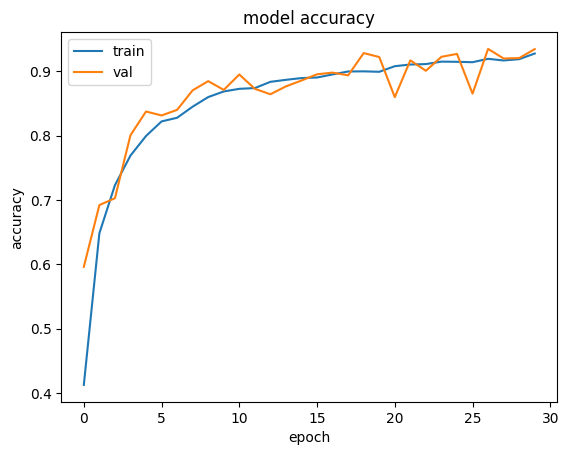

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

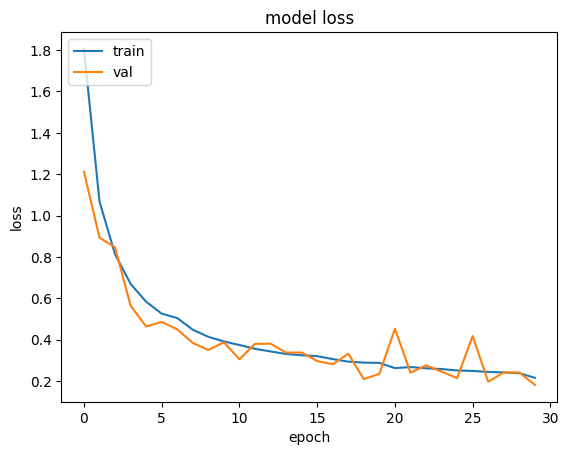

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

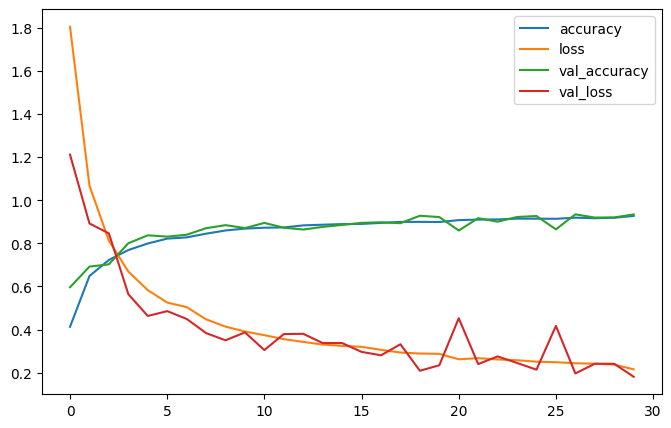

In [32]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

In [33]:
import shap
import numpy as np

/home/osita/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:
for d in train_ds:
    X, y = d[0].numpy(), d[1].numpy()
    break

In [49]:
# def map2layer(X, layer):
#     feed_dict = dict(zip([model.layers[0].input], X))
#     return K.get_session().run(model.layers[layer].input, feed_dict)

In [50]:
# to_explain= X[[1,2]]

# layer = 9
# explainer = shap.GradientExplainer((model.layers[layer].input, model.layers[-1].output),
#                                    map2layer(X.copy(), layer),)

# shap_values, indexes = explainer.shap_values(map2layer(to_explain, layer), ranked_outputs=2)

# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# shap.image_plot(shap_values, index_names, index_names)

In [51]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [52]:
print(X.shape,y.shape)

(8, 64, 64, 3) (8,)


In [53]:
def f(X):
    tmp = X.copy()
    return model(tmp)

In [54]:
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

In [55]:
explainer = shap.Explainer(f, masker, output_names=class_names)

In [56]:
shap_value = explainer(X, max_evals=5000, batch_size=500, outputs=shap.Explanation.argsort.flip[:3])


PartitionExplainer explainer: 9it [03:05, 23.21s/it]                       


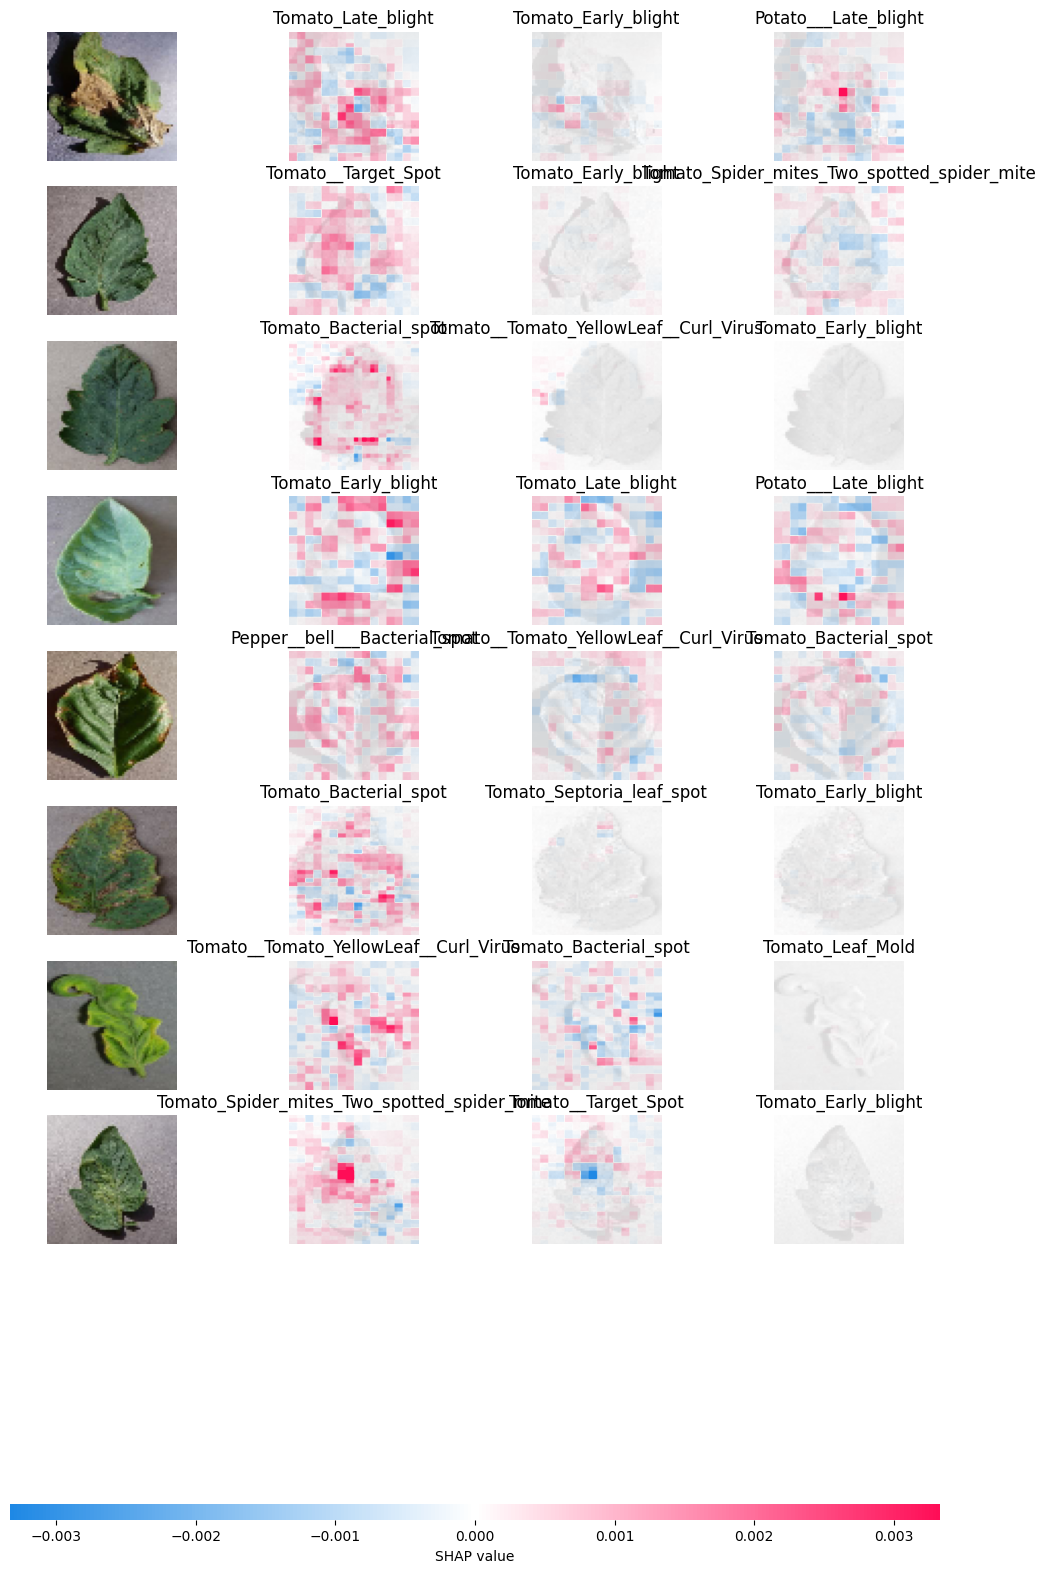

In [57]:
shap.image_plot(shap_value, X/255)

In [44]:
shap_value.shape

(8, 64, 64, 3, 3)

In [3]:
tf.keras.models.load_model("../models/1.keras")

TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [8, 64, 64, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Resizing', 'config': {'name': 'resizing', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'height': 64, 'width': 64, 'interpolation': 'bilinear', 'crop_to_aspect_ratio': False, 'pad_to_aspect_ratio': False, 'fill_mode': 'constant', 'fill_value': 0.0, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}, {'module': 'keras.layers', 'class_name': 'Rescaling', 'config': {'name': 'rescaling', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'scale': 0.00392156862745098, 'offset': 0.0}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomFlip', 'config': {'name': 'random_flip', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'seed': None, 'mode': 'horizontal_and_vertical'}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'filters': 32, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [8, 62, 62, 32]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 31, 31, 32]}}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [8, 29, 29, 64]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'conv2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'filters': 64, 'kernel_size': [3, 3], 'strides': [1, 1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 14, 14, 64]}}, {'module': 'keras.layers', 'class_name': 'MaxPooling2D', 'config': {'name': 'max_pooling2d_2', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'pool_size': [2, 2], 'padding': 'valid', 'strides': [2, 2], 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [8, 12, 12, 64]}}, {'module': 'keras.layers', 'class_name': 'Flatten', 'config': {'name': 'flatten', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [8, 6, 6, 64]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 2304]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'units': 15, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 64]}}], 'build_input_shape': [8, 64, 64, 3]}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'Adam', 'config': {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: <class 'keras.src.layers.preprocessing.image_preprocessing.random_rotation.RandomRotation'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None, 'shared_object_id': 135383360711616}, 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [8, 64, 64, 3]}}.

Exception encountered: Error when deserializing class 'RandomRotation' using config={'name': 'random_rotation', 'trainable': True, 'dtype': 'float32', 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}.

Exception encountered: Unrecognized keyword arguments passed to RandomRotation: {'value_range': [0, 255]}